<Figure size 720x576 with 0 Axes>

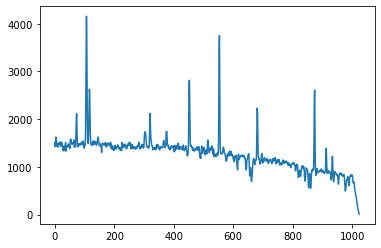

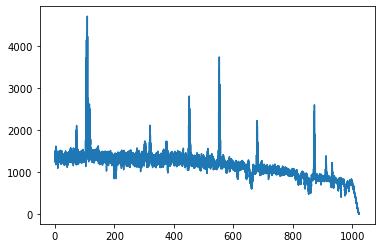

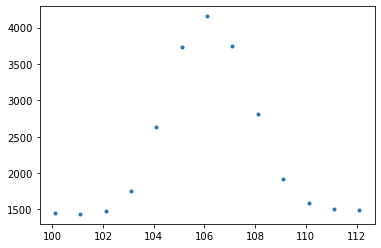

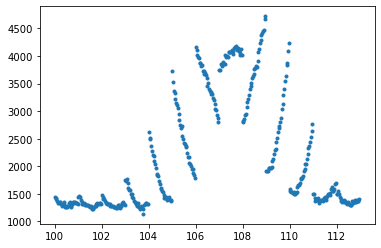

In [11]:
# import packages
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []
for i in range(filesize):
    n = i + 22 # fits index starts from 22
    if n < 100:
        hdu_data = fits.getdata(filepath + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < 112: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 112:
        break
nirspec7_data_array = np.array(nirspec7_data)

# sky 51, 59; obect 52 to 58
data51 = nirspec7_data_array[29] # sky
data53 = nirspec7_data_array[31] # object

# remove sky background
subtracted = data53 - data51

# show reduced fits
plt.figure(figsize=(10,8))
#plt.imshow(subtracted)
#plt.colorbar(orientation='horizontal', pad=0.05)

# load waverange
waverange = fits.open(filepath + 'waverange.fits', ignore_missing_end=True)[0].data


# plot cropped slit
pixel = np.linspace(0, 1024, 1024)
selected_slit = subtracted[50]

plt.figure()
plt.plot(pixel, selected_slit)

# Obtain more slits
multi_slit = subtracted[50:80]
multi_pixel = np.linspace(0, 1024, 1024*len(multi_slit))
flattened_slit = np.ravel(multi_slit.T)

plt.figure()
plt.plot(multi_pixel, flattened_slit)

# select certain waverange/pixel
#index = np.where((waverange>2.1216) & (waverange<2.12197))
index = np.where((pixel>100)*(pixel<113))
multi_index = np.where((multi_pixel>100)*(multi_pixel<113))

# plot slit with selected waverange/pixel
plt.figure()
plt.plot(pixel[index], selected_slit[index],'.')
plt.figure()
plt.plot(multi_pixel[multi_index], flattened_slit[multi_index],'.')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 390
    # variables        = 3
    chi-square         = 7.84463735
    reduced chi-square = 0.02027038
    Akaike info crit   = -1517.46347
    Bayesian info crit = -1505.56503
[[Variables]]
    amp:   0.74335295 +/- 0.01707285 (2.30%) (init = 1)
    mu:    107.600617 +/- 0.05209915 (0.05%) (init = 107)
    fwhm:  4.62761792 +/- 0.12305013 (2.66%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, fwhm) = -0.578


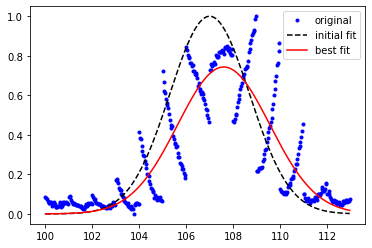

In [13]:
def normalization(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

#normalized = normalization(selected_slit[index])
normalized = normalization(flattened_slit[multi_index])

#x = pixel[index]
x = multi_pixel[multi_index]
y = normalized

def gaussian(x, amp, mu, fwhm): 
    sig = fwhm / (2*np.sqrt(2*np.log(2)))
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


gmodel = Model(gaussian)
#print('parameter names: {}'.format(gmodel.param_names))
#print('independent variables: {}'.format(gmodel.independent_vars))

params = gmodel.make_params(amp=1, mu=107, fwhm=4)
result = gmodel.fit(y, params, x=x)

print(result.fit_report())

plt.figure()
#plt.plot(pixel[index], normalized, 'g-', label='original curve')
plt.plot(x, y,'b.', label='original')
plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(x, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

for n in range(224): #We use this list to create a list which holds all the data from Order19
    num = n + 76
    if num < 100:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_00' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    elif num < 192 and num >= 100:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_0' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    elif num >= 192 and num < 196:
        print('Star files')
    elif num >= 196 and num < 296:
        image_filei = 'D:/Python work/Keck 05Sept06 Data/Keck 05Sept06 Data/05Sep06 Observations/uranus/order19/05sep06_0' + str(num) + '.fits'
        fits.open(image_filei)
        image_datai = fits.getdata(image_filei, ext=0)
        Keck_Data.append(image_datai)
    else:
        print('Galaxy files')

notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/order36/')


hdu_list1 = fits.open(filepath + 'jun02s0043_order36.fits', ignore_missing_end=True)
hdu_list2 = fits.open(filepath + 'jun02s0044_order36.fits', ignore_missing_end=True)
hdu_list3 = fits.open(filepath + 'jun02s0045_order36.fits', ignore_missing_end=True)
hdu_list4 = fits.open(filepath + 'jun02s0046_order36.fits', ignore_missing_end=True)

hdu_list5 = fits.open(filepath + 'jun02s0047_order36.fits', ignore_missing_end=True)
hdu_list6 = fits.open(filepath + 'jun02s0048_order36.fits', ignore_missing_end=True)
hdu_list7 = fits.open(filepath + 'jun02s0049_order36.fits', ignore_missing_end=True)
hdu_list8 = fits.open(filepath + 'jun02s0050_order36.fits', ignore_missing_end=True)


data1 = hdu_list1[0].data
data2 = hdu_list2[0].data
data3 = hdu_list3[0].data
data4 = hdu_list4[0].data

data5 = hdu_list5[0].data
data6 = hdu_list6[0].data
data7 = hdu_list7[0].data
data8 = hdu_list8[0].data

sum_A = data1 + data4 + data5 + data8
sum_B = data2 + data3 + data6 + data7

plt.figure(figsize=(8,8))
plt.imshow(sum_B - sum_A)
plt.colorbar()

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure(figsize=(10,8))
ax = plt.gca()
im = ax.imshow(data53 - data51)

#### create an axes on the right side of ax. The width of cax will be 5%
#### of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)